In [1]:
import tensorflow as tf 
print(tf.__version__) 
tf.test.is_gpu_available()

2.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12097614141166477261
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6300696576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14116063340178802261
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import numpy as np
import pandas as pd

from math import ceil
from numba import njit, prange
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from pyts.preprocessing import MinMaxScaler
from pyts.approximation import PiecewiseAggregateApproximation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
import os
import cv2

In [4]:
Welding_data = np.load('E:/Result/ver.3.22/MTF/MTF.npz')

X_data = Welding_data['X_data']
y_data = Welding_data['y_data']
i_data = Welding_data['i_data']

Welding_data.close()

In [5]:
print(y_data)

[2 1 2 ... 0 1 2]


In [6]:
seed = 7
np.random.seed()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data,y_data,i_data, test_size = 0.2, shuffle = True, random_state = seed)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(943, 300, 300, 2)
(943,)
(236, 300, 300, 2)
(236,)


In [8]:
inputs = np.concatenate((X_train,X_test))
targets = np.concatenate((y_train,y_test))
index = np.concatenate((i_train,i_test))

In [9]:
targets = np_utils.to_categorical(targets)
print(targets)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [10]:
import tensorflow as tf

In [11]:
# DenseNet

In [12]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Input, Activation, Flatten, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization.batch_normalization import BatchNormalization

In [13]:
input = Input(shape=(300, 300, 2))
model = DenseNet121(input_tensor=input, include_top=False, weights=None, pooling='avg')
 
x = model.output
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax', name='softmax')(x)

model = Model(model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 2  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 306, 306, 2)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 150, 64  6272        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [14]:
from tensorflow import keras

In [15]:
#keras.utils.plot_model(model, show_shapes=True, to_file='DenseNet121.png')

In [16]:
import keras.backend as K

from keras.callbacks import Callback

class LearningRateSchedule(Callback):
    def __init__(self, selected_epochs=[]):
        self.selected_epochs = selected_epochs
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) in self.selected_epochs:
            lr = K.get_value(self.model.optimizer.lr)
            K.set_value(self.model.optimizer.lr, lr*0.1)

In [17]:
# 학습데이터의 log를 저장할 폴더 생성(지정)
import datetime

log_dir = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 텐서보드 콜백 정의 하기
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir, histogram_freq= 1)

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

test = []
train= []
test_ = []
train_ = []
for train, test in kfold.split(inputs, targets):
    print(len(test))
    print(len(train))
    for i in zip(test):
        test_.append(i)
    for i in zip(train):
        train_.append(i)

118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
117
1062


In [19]:
train = train_[0:1061]
train = np.reshape(train, 1061)
test = test_[0:118]
test = np.reshape(test, 118)

In [20]:
print(test)
print(train)
print(index[test])
print(targets[test])

[   9   17   34   40   46   53   54   83   97  101  109  113  128  140
  141  146  168  171  179  186  204  228  253  263  264  280  306  316
  358  372  374  377  379  389  412  422  431  432  446  449  459  463
  467  473  484  492  508  509  510  513  523  551  564  571  597  602
  620  631  632  642  663  665  666  685  698  716  724  729  732  734
  756  761  771  793  797  804  815  819  831  836  840  841  879  883
  884  890  907  912  915  920  936  941  946  955  963  975  982  983
  985 1003 1013 1025 1047 1050 1053 1067 1070 1077 1083 1102 1105 1111
 1120 1154 1166 1172 1177 1178]
[   0    1    2 ... 1174 1175 1176]
['P_282' 'N_252' 'P_327' 'H_260' 'N_303' 'H_232' 'P_44' 'N_110' 'P_0'
 'H_369' 'P_191' 'N_244' 'N_178' 'H_137' 'H_156' 'P_220' 'H_277' 'P_382'
 'H_108' 'N_79' 'H_45' 'H_12' 'N_85' 'P_153' 'N_185' 'P_82' 'N_46' 'H_375'
 'P_80' 'N_120' 'H_192' 'P_328' 'H_377' 'N_247' 'H_251' 'H_217' 'N_52'
 'P_193' 'P_173' 'P_62' 'N_336' 'N_275' 'P_242' 'N_352' 'N_194' 'P_371'
 'H

In [21]:
# K-fold Cross-validation

In [23]:

os.mkdir('E:/Result/ver.3.28/MTF/'+ 'weight')
os.mkdir('E:/Result/ver.3.28/MTF/'+ 'train')
os.mkdir('E:/Result/ver.3.28/MTF/'+ 'test')

In [37]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

acc_per_fold = []
loss_per_fold = []

kfold = StratifiedKFold(n_splits=10, shuffle=True)

fold_no = 1

with tf.device('/gpu:0'):
    for train, test in kfold.split(X_train, y_train):
        print(train.shape, test.shape)
        
        np.savetxt('E:/Result/ver.3.28/MTF/train/' + f'train_{fold_no}.csv', train, delimiter=",")
        np.savetxt('E:/Result/ver.3.28/MTF/test/' + f'test_{fold_no}.csv', test, delimiter=",")

        input = Input(shape=(300, 300, 2))
        model = DenseNet121(input_tensor=input, include_top=False, weights=None, pooling='avg')
        
        x = model.output

        x = Dense(3, activation='softmax', name='softmax', kernel_initializer='he_normal')(x)
        model = Model(model.input, x)

        
        optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
        #optimizer = optimizers.Adam(lr=0.001)
        
        callbacks_list = [LearningRateSchedule([20,40])]
        
        check_point_cb = keras.callbacks.ModelCheckpoint(
          f'best_MTF_avg_DenseNet_model_{fold_no}.h5',
          save_best_only= True
        )
        
        early_stopping_cb = keras.callbacks.EarlyStopping(
          patience= 2,
          restore_best_weights= True
        )
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        history = model.fit(inputs[train], targets[train], 
                            batch_size=4, 
                            epochs=100, 
                            verbose=1,
                            validation_data=(inputs[test], targets[test]),
                            callbacks = tensorboard_callback) 
        
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        
        #model.save('E:/Result/ver.3.28/MTF/weight/' + f'MTF_{fold_no}.h5',fold_no)
        
        fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

(848,) (95,)


C:\Users\jwhyu\anaconda3\envs\venv\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
212/212 [==============================] - 28s 110ms/step - loss: 9.7048 - accuracy: 0.4870 - val_loss: 190.1291 - val_accuracy: 0.4316
Epoch 2/100
 42/212 [====>.........................] - ETA: 16s - loss: 3.1637 - accuracy: 0.5060

KeyboardInterrupt: 

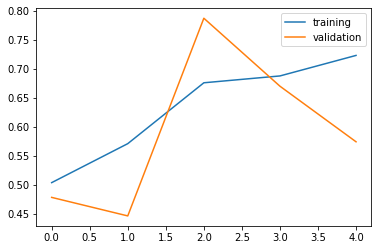

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'], loc='upper right')
plt.show()

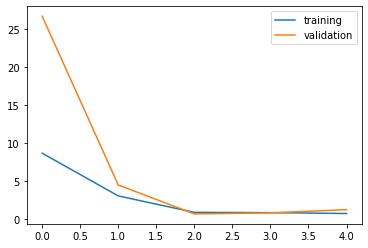

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'], loc='upper right')
plt.show()